# Milestone Poject 2 : skimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here : https://arxiv.org/abs/1710.06071
        
And reading through the paper above, we see that the model architecture that they use to achieve their best results is available : https://arxiv.org/abs/1612.05251
        
*Resource :* If you want to find the ground truth for this notebook(with lots of diagrams and text annotation) see the Github: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb



In [3]:
# Import dependencies
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
# sys.path.append(r"C:\Users/wjub/01workspace/TensorFlow Developer Certificate ZTM")
sys.path.append(r"/content/drive/MyDrive/TensorFlow_Developer_Certificate_ZTM/")

import helper_functions
from helper_functions import calculate_results
import random


In [4]:
# Confirm acces to GPU
!nvidia-smi

Fri Feb 10 20:14:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get data

Since we'll be replicating the paper above (PubMed 200K RCT)? let's download the dataset they used,
We can do so from the authors GitHub : 

In [5]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
# Check what files are in the PubMed_20K dataset


fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [6]:
ls pubmed-rct

PubMed_200k_RCT/
PubMed_200k_RCT_numbers_replaced_with_at_sign/
PubMed_20k_RCT/
PubMed_20k_RCT_numbers_replaced_with_at_sign/
README.md


In [7]:
ls pubmed-rct/PubMed_20k_RCT

dev.txt  test.txt  train.txt


In [8]:
# Start our experiments using the 20k dataset with numbers replaced by "#" sign
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [9]:
# Check all of the filenames in the target directory
import os
filenames= [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data 

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with data is to...

> Visualize, visualize, vizualize

So with that in mind, let's write a function to read in all of the lines of a target text file.

In [10]:
# Create function to read lines of a document
def get_lines(filename):
    """
    Reads filename (a text filename) and returns the line of text as list.
    
    Args:
    	filename: a string containing the target filepath.
    Returns:
    	A list of strings with one string with one string per line from the target filename.  
    """
    with open(filename, "r") as f:
        return f.readlines()

In [11]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt")
train_lines[:30]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [12]:
len(train_lines)

210040

In [13]:
from helper_functions import preprocess_text_with_line_numbers

In [14]:
# Get data from file and preprocess it 
%time
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt") # dev is another name for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.44 µs
180040 30212 30135


Now that our data is the frormat of a list of ditionaries, how about we turn it into dataframe to futher visualize it?

In [15]:
# check the first abstract_line
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(train_samples)
test_df = pd.DataFrame(train_samples)
#train_df["target"] = numeric_labels
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11


In [16]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

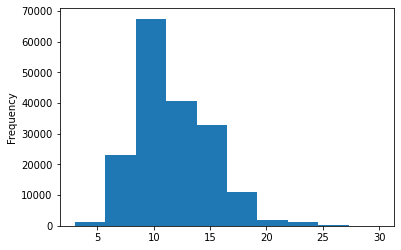

In [17]:
# let's check length of different lines
train_df.total_lines.plot.hist()

### Get lists of senteces

In [18]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)


(180040, 180040, 180040)

In [19]:
# View the 10 lines o ftraining sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

In [20]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # we want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1,1))

# check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [21]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

###  Label encode labels

In [22]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"])
val_labels_encoded = label_encoder.fit_transform(val_df["target"])
test_labels_encoded = label_encoder.fit_transform(test_df["target"])

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [23]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Starting a series of modelling experiments...

As usual, we're going to be trying out a bunch of different models ans seeing which one works best.

And as always, we're going to start with a baseline (TF-IDF Multinomial Naive Bayes classifier).

## Model_0 : Getting a baseline

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline ([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])
# fit the pipeline to the training data
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [25]:
# Evaluate the model
baseline_score = model_0.score(val_sentences,val_labels_encoded)
print(f"our baseline model achive an accuracy of : {baseline_score}")

our baseline model achive an accuracy of : 0.7516829593423684


In [26]:
# make prediction
baseline_pred_probs = model_0.predict(val_sentences)
baseline_preds = tf.squeeze(tf.round(baseline_pred_probs))
baseline_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([1, 2, 4, 2, 2, 4, 4, 4, 4, 4])>

In [27]:
model_0_results = helper_functions.calculate_results(val_labels_encoded, baseline_preds)
model_0_results

{'accuracy': 75.16829593423684,
 'precision': 0.7556121877731266,
 'recall': 0.7516829593423684,
 'f1': 0.734085177322999}

## Prepare our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers

In [28]:
# how long is each sentence on average ? 
sent_lens = [len(sentence.split()) for sentence in train_sentences] # list of length of words
avg_sent_len = np.mean(sent_lens)
avg_sent_len
#avg_sent_len, nb_word_per_sentence/len(train_sentences)

26.338269273494777

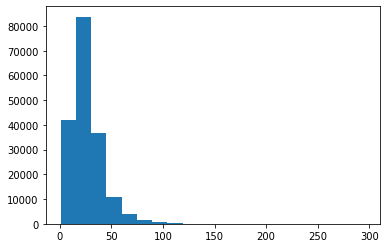

In [29]:
plt.hist(sent_lens, bins=20);

In [30]:
# How long  of sentence lenght covers 95% of examples
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len 

55

In [31]:
# Maximum sequence length in the training set
max(sent_lens)

296

## Embedding and tokenization
We want to make a layer which maps our texts from words to numbers

In [32]:
# How many words are in our vocab? (taken from table 2 in : https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [33]:
# lets create a text vectorizer use text vectorisation layers of the last video
from helper_functions import tokenization, embedding
# init the tokenizer function
init_tokenizer = tokenization(train_sentences, output_seq_len, max_vocab_length=68000) 

# Choose a random sentence from the training dataset and tokenize it 
random_sentence = random.choice(train_sentences)
text_vectorizer = init_tokenizer([random_sentence])


In [34]:
# How many words in our training vocabulary
rct_20k_text_vocab = init_tokenizer.get_vocabulary()
print(f"Number of words i vocab:{len(rct_20k_text_vocab)}\n")
print(f"Most common words in the vocab:{rct_20k_text_vocab[:5]}\n")
print(f"least common words in the vocab:{rct_20k_text_vocab[-5:]}\n")

Number of words i vocab:64841

Most common words in the vocab:['', '[UNK]', 'the', 'and', 'of']

least common words in the vocab:['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']



In [35]:
init_tokenizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Create custom text embedding

In [36]:
# Init embedding 
init_embedding = embedding( output_seq_len,len(rct_20k_text_vocab), output_seq_len)
text_embedding = init_embedding(text_vectorizer)
text_embedding

<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
array([[[ 0.00267868, -0.00070303, -0.04830797, ...,  0.01644666,
          0.04563631, -0.04851718],
        [ 0.02002859,  0.03595719,  0.03621138, ..., -0.00943268,
         -0.00271808, -0.01829033],
        [ 0.03714383, -0.00515593,  0.00554518, ..., -0.01713927,
          0.04161796,  0.04231216],
        ...,
        [ 0.03778983,  0.01258094,  0.00674689, ..., -0.02557713,
          0.02805182,  0.00436882],
        [ 0.03778983,  0.01258094,  0.00674689, ..., -0.02557713,
          0.02805182,  0.00436882],
        [ 0.03778983,  0.01258094,  0.00674689, ..., -0.02557713,
          0.02805182,  0.00436882]]], dtype=float32)>

In [37]:
# Show example embedding
print(f"Sentence before vectorization:\n {random_sentence}\n")
print(f"sentence after vectorization: \n {text_vectorizer}")
print(f"sentence after embedding: \n {text_embedding}")
print(f"embedding sentence shape:\n {text_embedding.shape}")

Sentence before vectorization:
 patients were evaluated according to subjective criteria , functional assessment tests , knee isometric torques , knee laxity using kt-@ and knee range of motion .

sentence after vectorization: 
 [[   12     9   184   374     6   822   391   304   250   549   517  3379
  19429   517  8893    59  3693     3   517   283     4  1322     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
sentence after embedding: 
 [[[ 0.00267868 -0.00070303 -0.04830797 ...  0.01644666  0.04563631
   -0.04851718]
  [ 0.02002859  0.03595719  0.03621138 ... -0.00943268 -0.00271808
   -0.01829033]
  [ 0.03714383 -0.00515593  0.00554518 ... -0.01713927  0.04161796
    0.04231216]
  ...
  [ 0.03778983  0.01258094  0.00674689 ... -0.02557713  0.02805182
    0.00436882]
  [ 0.03778983  0.01258094  0.00674689 ... -0.02557713  0.02805

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast a possible with the TensorFlow tf.data API, many of the steps here are discussed at length in these two resources:
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [38]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [39]:
train_labels_one_hot.shape, train_labels_one_hot[0]

((180040, 5), array([0., 0., 0., 1., 0.]))

In [40]:
# Take the TensorSliceDataset's and turn them into prefechted data
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [41]:
len(train_dataset)

5627

## Model 1 : Conv1D with token embeddings

In [42]:
# Create 1D conv model to process sequences
num_classes

5

In [43]:
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Dense, Input
# create victorization, create embedding layer, create conv1D, pooling, dense layer
model_1 = tf.keras.Sequential([
    Input(shape=(1), dtype=tf.string, name='input_layer'),
    init_tokenizer,
    init_embedding,
    Conv1D(64, kernel_size=5, padding='same', activation='relu'),
    GlobalAveragePooling1D(), # Condense the output of our feature vector from conv layer
    Dense(num_classes, activation='softmax')
], name='Conv1D')

# compile the model
model_1.compile(loss= "categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])
model_1.summary()

Model: "Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 8,340,997
Trainable params: 8,340,997
Non-trai

In [44]:
# fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)), 
                              epochs=3,
                              validation_data= valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)),
                              callbacks=[helper_functions.create_tensorboard_callback(dir_name="tensorboard",
                                                                                    experiment_name="model_1_conv1D")])

Saving TensorBoard log files to: tensorboard/model_1_conv1D/20230210-201442
Epoch 1/3
562/562 [==============================] - 14s 18ms/step - loss: 0.9192 - accuracy: 0.6390 - val_loss: 0.5581 - val_accuracy: 0.7983
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6576 - accuracy: 0.7574 - val_loss: 0.5424 - val_accuracy: 0.8164
Epoch 3/3
562/562 [==============================] - 11s 20ms/step - loss: 0.6191 - accuracy: 0.7742 - val_loss: 0.5272 - val_accuracy: 0.8200


In [45]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

5627/5627 [==============================] - 28s 5ms/step - loss: 0.5728 - accuracy: 0.7993


[0.5728352665901184, 0.799283504486084]

In [46]:
# Make predictions (our model predicts prediction probabilies for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape # output = proba of ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']


5627/5627 [==============================] - 16s 3ms/step


(array([[3.3381633e-02, 2.2047864e-02, 2.0006399e-05, 9.4455034e-01,
         1.2632579e-07],
        [3.2234451e-04, 3.6450211e-04, 9.3369424e-01, 1.4026451e-04,
         6.5478630e-02],
        [2.0540411e-02, 7.2916679e-02, 4.7241464e-01, 1.2036702e-02,
         4.2209160e-01],
        ...,
        [2.3709983e-02, 2.8207970e-01, 5.0058421e-02, 1.3434954e-02,
         6.3071698e-01],
        [3.9596319e-02, 7.2824228e-01, 9.6712345e-03, 4.3478634e-02,
         1.7901160e-01],
        [4.7687024e-01, 7.1354359e-02, 1.4755790e-01, 2.8975618e-01,
         1.4461390e-02]], dtype=float32), (180040, 5))

In [47]:
# Convert pred_probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(180040,), dtype=int64, numpy=array([3, 2, 2, ..., 4, 1, 0])>

In [48]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_1_preds)
model_1_results

{'accuracy': 79.92834925572096,
 'precision': 0.7971510818888089,
 'recall': 0.7992834925572095,
 'f1': 0.7973255123322279}

## Model_2 : TensorFlow Hub Pretrained Feature Extractor

Now lets use pretrained word embedding from TensorFlow Hub, more specifically the universal sentence encoder(universal-sentence-encoder): https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVee embeddings, however, we're going to stick with the later created USE pretrained embedding

In [49]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                  trainable=False,
                                  name="universal_sentence_encoder")
embeddings = tf_hub_embedding_layer([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])

print(embeddings)

tf.Tensor(
[[-0.03133018 -0.06338634 -0.01607501 ... -0.0324278  -0.04575739
   0.05370454]
 [ 0.05080861 -0.01652432  0.01573778 ...  0.0097666   0.03170121
   0.01788117]], shape=(2, 512), dtype=float32)


In [50]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"sentence after embedding:\n{use_embedded_sentence[0][:30]}")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 y-@ was shown to be a safe and potentially effective natural alternative for enhancing immune function .
sentence after embedding:
[-0.04395106 -0.00307627 -0.05646475 -0.04011718  0.00555978  0.06208301
 -0.03073876  0.00656566  0.07308497  0.04731559  0.04950152 -0.02935939
  0.00012837  0.0601956  -0.01219307 -0.03047445 -0.06373495 -0.05017061
 -0.01333459  0.05755365  0.02467374 -0.07831644 -0.04307533  0.05935572
  0.00506777  0.05556967 -0.00423931  0.05281248  0.05609311  0.05253641]
Length of sentence embedding: 512


## Building and fitting an NLP feature extraction model using pretrained embeddings from TensorFlow Hub 

In [51]:
model_2 = tf.keras.Sequential([
    tf_hub_embedding_layer,
    tf.keras.layers.Dense(5, activation='sigmoid')
])
# compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [52]:
# fit the model
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1*len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1*len(valid_dataset)),
            callbacks=[helper_functions.create_tensorboard_callback(dir_name="tensorboard",
                                                                    experiment_name="model_2_tf_hub_embed")])

Saving TensorBoard log files to: tensorboard/model_2_tf_hub_embed/20230210-201622
Epoch 1/3
562/562 [==============================] - 25s 35ms/step - loss: 1.2555 - accuracy: 0.5497 - val_loss: 1.0841 - val_accuracy: 0.6030
Epoch 2/3
562/562 [==============================] - 14s 24ms/step - loss: 1.0094 - accuracy: 0.6271 - val_loss: 0.9579 - val_accuracy: 0.6514
Epoch 3/3
562/562 [==============================] - 17s 30ms/step - loss: 0.9298 - accuracy: 0.6569 - val_loss: 0.8993 - val_accuracy: 0.6720


In [53]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[], dtype="string"),
    tf_hub_embedding_layer, # tokenize text and create embedding of each sequence (512 long vector)
    tf.keras.layers.Dense(128, activation="relu"),
    # Note : you could add more layers here if you wanted to
    tf.keras.layers.Dense(num_classes, activation='sigmoid', name="output_layer")
], name="model_2_tf_hub_embed")

# compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [54]:
# fit the model
history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)),
                              callbacks=[helper_functions.create_tensorboard_callback(dir_name="tensorboard",
                                                                    experiment_name="model_2_tf_hub_embed")])

Saving TensorBoard log files to: tensorboard/model_2_tf_hub_embed/20230210-201749
Epoch 1/3
562/562 [==============================] - 19s 31ms/step - loss: 0.9136 - accuracy: 0.6509 - val_loss: 0.7817 - val_accuracy: 0.7044
Epoch 2/3
562/562 [==============================] - 17s 30ms/step - loss: 0.7717 - accuracy: 0.6997 - val_loss: 0.7556 - val_accuracy: 0.7125
Epoch 3/3
562/562 [==============================] - 13s 24ms/step - loss: 0.7562 - accuracy: 0.7097 - val_loss: 0.7461 - val_accuracy: 0.7116


In [69]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

5627/5627 [==============================] - 73s 13ms/step - loss: 0.7482 - accuracy: 0.7111


[0.7481958866119385, 0.7111364006996155]

In [56]:

# Make some prediction wit feature extraction model
model_2_pred_probs = model_2.predict(val_sentences)

5627/5627 [==============================] - 70s 12ms/step


In [57]:
# convert the prediction probabilities found with feature extraction model to label
model_2_pred = tf.argmax(model_2_pred_probs, axis=1) # les positions des  valeur les plus grandes 
model_2_pred

<tf.Tensor: shape=(180040,), dtype=int64, numpy=array([3, 2, 2, ..., 1, 1, 2])>

In [58]:
# Calcute results performance from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true =val_labels_encoded,
                                    y_pred = model_2_pred)
model_2_results

{'accuracy': 71.11364141301932,
 'precision': 0.71299943739095,
 'recall': 0.7111364141301932,
 'f1': 0.7085692740126678}

In [59]:
model_0_results

{'accuracy': 75.16829593423684,
 'precision': 0.7556121877731266,
 'recall': 0.7516829593423684,
 'f1': 0.734085177322999}

In [60]:
model_1_results

{'accuracy': 79.92834925572096,
 'precision': 0.7971510818888089,
 'recall': 0.7992834925572095,
 'f1': 0.7973255123322279}

## Model 3: Conv1D with character embeddngs

The paper which we're replicating states they used a combination of token and character-level embeddings.

Previously we've token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.

### Create a characterlevel tokenizer

In [61]:
# tr = train_sentences.split("")
#init_tokenizer
type(train_sentences)

list

In [62]:
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

'y - @   w a s   s h o w n   t o   b e   a   s a f e   a n d   p o t e n t i a l l y   e f f e c t i v e   n a t u r a l   a l t e r n a t i v e   f o r   e n h a n c i n g   i m m u n e   f u n c t i o n   .'

In [63]:
# Split sequence-level data splits into character-level data splits 
train_chars = [split_chars(sentence) for sentence in train_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [64]:
# What's the average character length ?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

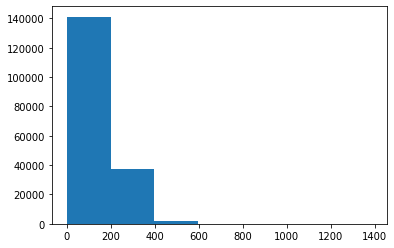

In [65]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [66]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [67]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [86]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, '[UNK]')


    # Create a text vectorizer 
char_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                                                               output_sequence_length= output_seq_char_len,
                                                                               #standardize=None, # set standardization to "None" if you want leave the ponctuation in
                                                                               name="char_vectorizer")


In [87]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [88]:
 # Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [94]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of random_train_chars: {len(random_train_chars)}")

vectorized_chars = char_vectorizer([random_train_chars])
print(f"\Vectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 d u r i n g   e n u c l e a t i o n   ,   s e r u m   c o n c e n t r a t i o n s   o f   a d r e n a l i n e   ,   n o r a d r e n a l i n e   ,   a n d   d o p a m i n e   i n c r e a s e d   ,   f o l l o w e d   b y   a   r i s e   o f   s y s t o l i c   a n d   d i a s t o l i c   b l o o d   p r e s s u r e   i n   t h e   g r o u p   o f   p a t i e n t s   t h a t   r e c e i v e d   o n l y   g e n e r a l   a n e s t h e s i a   .
Length of random_train_chars: 445
\Vectorized chars:
 [[10 16  8  4  6 18  2  6 16 11 12  2  5  3  4  7  6  9  2  8 16 15 11  7
   6 11  2  6  3  8  5  3  4  7  6  9  7 17  5 10  8  2  6  5 12  4  6  2
   6  7  8  5 10  8  2  6  5 12  4  6  2  5  6 10 10  7 14  5 15  4  6  2
   4  6 11  8  2  5  9  2 10 17  7 12 12  7 20  2 10 22 19  5  8  4  9  2
   7 17  9 19  9  3  7 12  4 11  5  6 10 10  4  5  9  3  7 12  4 11 22 12
   7  7 10 14  8  2  9  9 16  8  2  4  6  3 13  2 18  8  7 16 14  7 17 14
   5  3  4  2  6  3  9  3 13  5  3  8  